# User Allocation Service - How do we know it is working correctly?

## A common data quality issue in ab testing tools is Sample Ratio Mismatch

## What is Sample Ratio Mismatch?
Sample Ratio Mismatch happens when the frequency of allocation of users in the ab testing tool drifts or skews away from the ratio which has been defined for an experiment (or group of experiments).

### Example: The ratio is set to 50:50 but an implementation issue or scaling issue in the API means fewer responses are received for variant B. This would lead to an artificial skew towards variant B.

This can happen both at the Allocation Service end (before code is delivered to a user) and at the application end (for example, due to a bias from one of the variants like page speed or a failure for events to fire on the client).

It is necessary to detect Sample Ratio Mismatch (SRM) in BOTH places.

For further info, and more examples, I recommend downloading the following paper by the team at Booking.com: https://www.kdd.org/kdd2019/accepted-papers/view/diagnosing-sample-ratio-mismatch-in-online-controlled-experiments-a-taxonom

## What is the expected ratio for an AB test?

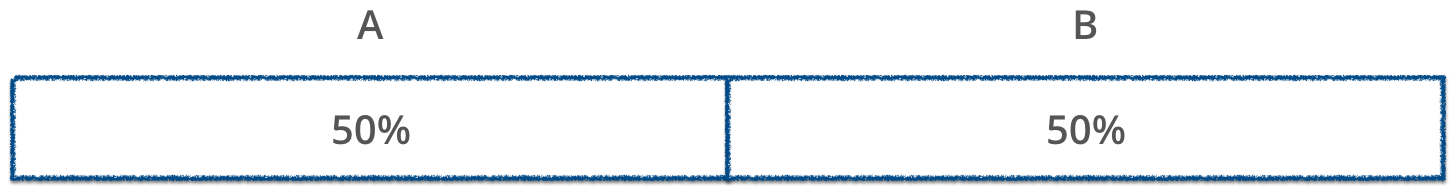

## What if the ratio is skewed 45:55, 40:60 or even further skewed? 

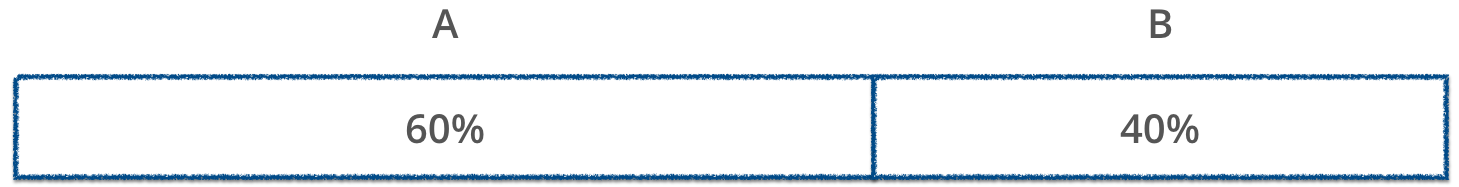

### 1) What does this mean and how do we detect it?
### 2) How do we know the significance is important?



# For this we need a statistical test!!!

In [1]:
import psycopg2
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import chisquare
import seaborn as sns
import nbconvert
from IPython.display import HTML, display, Math, Latex, Image
HTML('''<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js?config=TeX-MML-AM_CHTML' async></script>''')
HTML('''
<script>code_show=true; function code_toggle(){if (code_show){$('div.input').hide();}else{$('div.input').show();}code_show=!code_show}$( document ).ready(code_toggle);</script>
The raw code for this IPython notebook is by default hidden for easier reading. 
<br><a href="javascript:code_toggle()">Raw code toggle: click here.</a>''')


# Chi-Squared Goodness of Fit test for testing a Random Number Generator
### Used to test the Expected Sample Ratio of the User Allocation Service

### What is the Chi-Square goodness of fit test?
Chi-Square goodness of fit test is a non-parametric test used to find out whether the observed value of a given phenomena is significantly different from the expected value.  
The term goodness of fit is used to compare the observed sample ratio with the expected probability ratio within a given distribution.

### When to Use the Chi-Square Goodness of Fit Test
The chi-square goodness of fit test is appropriate when the following conditions are met:
- The sampling method is simple random sampling.
- The variable under study is categorical.
- The expected value of the number of sample observations in each level of the variable is at least 5.

### Procedure for running a Chi-squared test on a single experiment:
1. State the Hypothesis  
2. Check which statistic you need, and calculate degrees of freedom based on the number of experiment buckets  
3. Calculate the Expected ratios for each experiment, also dependent on the number of experiment buckets  
4. Calculate the Test Statistic across all the buckets  
5. Get a p value

### 1 State the Hypotheses
An hypothesis test requires a null hypothesis ($H_0$) and an alternative hypothesis ($H_1$). 
The hypotheses are stated in such a way that they are mutually exclusive: if one is true, the other must be false; and vice versa. 

#### 1.a For a chi-square goodness of fit test, the hypotheses take the following form:

+ **$H_0$ Null hypothesis:** The data are consistent with a specified distribution. Example: The sample ratio in an AB experiment is 50:50 (or $\pi$ = 0.5)

+ **$H_1$ Alternative hypothesis:** The data are not consistent with a specified distribution.

### 2 Calculate the degrees of freedom
For this test, the degrees of freedom (DF) is equal to the number of levels (k) of the categorical variable minus 1. Where k in this case is the number of experiment buckets.

DF = k - 1

#### 2.a Examples: 
- For an AB (or AA) test, the number of experiment buckets, k, is 2. Therefore, DF = 1
- For an ABC (or AAA) test, k=3 so DF=2



### 3 Expected frequency counts
The expected frequency counts at each level of the categorical variable are equal to the sample size times the hypothesized proportion from the null hypothesis:

$$E_i = np_i$$

### 4 Test statistic. 
The test statistic is a chi-square random variable (Χ2) defined by the following equation.

$$
{\chi}^2_{k-1}=n * \sum_{j=1}^{n} \frac{(O_j - E_j)^2}{E_j}\
$$

Where, 
 ${\chi}^2_{k-1}$ = Chi-Square Test Statistic with k-1 degrees of freedom
 $k$ = number of buckets in the experiment
 $O_j$ = observed value 
 $E_j$= expected value
 
As a result of running the Chi-squared test, we get and observed test statistic, ${\chi}^2_{k-1} observed$

### Next, either do 5a or 5b, both are provided below:

### 5a Observe the P-value of the test statistic and determine if it is above the lvel of significance we chose for this experiment
The P-value is the probability of observing a sample statistic as extreme as the test statistic. 
Since the test statistic is a chi-square, use the chisquare() function in python or the standard statistical tables for the Chi-square distribution to assess the probability associated with the test statistic. 
Use the degrees of freedom computed above.

### 5b Calculate the Critical Chi-squared Value for the p value at which we want to run the test:
For example, assume the significant level we wish to use for this experiment is 99.9%, therefore:

$$p = 0.999$$
$${\chi}^2_{k-1} critical  = 10.8276 $$

If  
$ {\chi}^2_{k-1} observed > {\chi}^2_{k-1} critical \implies $ We *reject* $H_0$ and suggest $H_1$ is tenable. 

$\therefore$ the distribution of UAS *MUST* give us undue concern, and we should investigate further. 

But, if 

$ {\chi}^2_{k-1} observed < {\chi}^2_{k-1} critical \implies $ We *cannot* reject $H_0$ and $H_0$ is tenable. 

$\therefore$ the distribution of UAS *should not* give us undue concern. 

### Visualising the Chi-squared distribution for multiple degrees of freedom:

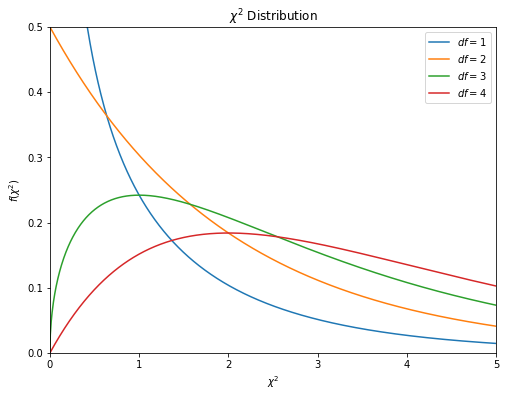

In [2]:
# chi square distribution with varying degrees of freedom
fig = plt.figure(figsize = (8, 6))
x = np.linspace(0, 5, 1000)
deg_of_freedom = [1, 2, 3, 4]
for df in deg_of_freedom:
    plt.plot(x, stats.chi2.pdf(x, df), label = '$df={}$'.format(df))

plt.xlim(0, 5)
plt.ylim(0, 0.5)
plt.xlabel('$\chi^2$')
plt.ylabel('$f(\chi^2)$')
plt.title('$\chi^2\ \mathrm{Distribution}$')
plt.legend()
plt.show()

#### Pre-step: read in simulation data from UAS

In [3]:
rng_df=pd.read_csv('UAS_RNG_data.csv',sep=';')
rng_df.head()

,visitorId,experimentKey,variantKey
0,9e4e3105-beeb-4c01-bd7e-cac80f0266c0,STAT-ANA-8,2out2
1,9e4e3105-beeb-4c01-bd7e-cac80f0266c0,STAT-ANA-7,2out2
2,9e4e3105-beeb-4c01-bd7e-cac80f0266c0,STAT-ANA-1,2out2
3,9e4e3105-beeb-4c01-bd7e-cac80f0266c0,STAT-ANA-2,1out2
4,9e4e3105-beeb-4c01-bd7e-cac80f0266c0,STAT-ANA-4,1out2


In [4]:
rng_df['visitorId'] = rng_df['visitorId'].astype(str)
rng_df['experimentKey'] = rng_df['experimentKey'].astype(str)
rng_df['variantKey'] = rng_df['variantKey'].astype(str)

rng_df_clean_1=rng_df
rng_df_clean_1['variantKey']=rng_df_clean_1['variantKey'].str.replace('out2', '')
rng_df_clean_1['experimentKey']=rng_df_clean_1['experimentKey'].str.lower()
rng_df_clean_1['experimentKey']=rng_df_clean_1['experimentKey'].str.replace('stat-ana-', '')

rng_df_clean_1['experimentKey'] = rng_df_clean_1['experimentKey'].astype(int)
rng_df_clean_1['variantKey'] = rng_df_clean_1['variantKey'].astype(int)


In [5]:
rng_df_clean_1=rng_df_clean_1.sort_values(['experimentKey','variantKey'], ascending=[True, True])
rng_df_clean_1= rng_df_clean_1.reset_index(drop=True)

### 1 Hypotheses

#### 1.a Hypotheses for UAS:

+ **$H_0$ Null hypothesis:** The sample ratio in an AB experiment is 50:50 (or $\pi$ = 0.5)

+ **$H_1$ Alternative hypothesis:** The sample ratio in an AB experiment is not 50:50 (or $\pi \neq$ 0.5)

In [6]:
experimentsRun = rng_df_clean_1[['experimentKey']].nunique()[0].astype(int)
print('Number of experiments run in this simulation =', experimentsRun)

Number of experiments run in this simulation = 10


In [7]:
countexpsdf2 = rng_df_clean_1.groupby(['experimentKey']).size().reset_index(name='observed_experiment')
print('The Number of observations per experiment is shown in the folowing table:')
countexpsdf2

The Number of observations per experiment is shown in the folowing table:


,experimentKey,observed_experiment
0,1,75000
1,2,75000
2,3,75000
3,4,75000
4,5,75000
5,6,75000
6,7,75000
7,8,75000
8,9,75000
9,10,75000


In [8]:
n = countexpsdf2['observed_experiment'].sum()
print("Total Observations collected across all experiments, n = ", n)

Total Observations collected across all experiments, n =  750000


In [9]:
variantCount = rng_df_clean_1[['variantKey']].nunique()[0]
print("Number of variants per experiment = ", variantCount)

Number of variants per experiment =  2


In [10]:
countvarsdf2 = rng_df_clean_1.groupby(['variantKey']).size().reset_index(name='observed_variant')
print('The number of observations per variant across all experiments is shown in the folowing table:')
countvarsdf2

The number of observations per variant across all experiments is shown in the folowing table:


,variantKey,observed_variant
0,1,374629
1,2,375371


In [11]:
countsFinal = countvarsdf2
countsFinal['expected_variant'] = (n/variantCount).astype(int)
print("Given the total Observations collected across all experiments, n = ", n, "and the number of variants", variantCount, "we can calculate the expected number of observations per variant by dividing n by the variant count:", (n/variantCount).astype(int))
countsFinal

Given the total Observations collected across all experiments, n =  750000 and the number of variants 2 we can calculate the expected number of observations per variant by dividing n by the variant count: 375000


,variantKey,observed_variant,expected_variant
0,1,374629,375000
1,2,375371,375000


In [12]:
countsFinal['observed_ratio'] = countsFinal['observed_variant']/n
countsFinal['expected_ratio'] = round(1/variantCount,2)
print("Given the summed observations per variant for all experiments we can calculate the observed ratio by dividing the number of observations per variant (", 
      countsFinal['observed_variant'][0],") by n (total observations):", n, )
print("This gives an observed ratio (in this example) of:", round(countsFinal['observed_variant'][0]/n,4) )
print("The expected ratio is given by 1 divided by the variant count, which is 1/2:" , round(1/variantCount,2) )

countsFinal

Given the summed observations per variant for all experiments we can calculate the observed ratio by dividing the number of observations per variant ( 374629 ) by n (total observations): 750000
This gives an observed ratio (in this example) of: 0.4995
The expected ratio is given by 1 divided by the variant count, which is 1/2: 0.5


,variantKey,observed_variant,expected_variant,observed_ratio,expected_ratio
0,1,374629,375000,0.499505,0.5
1,2,375371,375000,0.500495,0.5


In [13]:
Result = chisquare(countsFinal['observed_ratio'], f_exp=countsFinal['expected_ratio'])
print("Finally, we calculate the T-statistic and then multiply by n using the formula as given above:")
print("Observed Chi^2 Test Statistic = ", round(n*Result[0],4))
print("Observed p value = ", round(Result[1]*100,2),"%")

Finally, we calculate the T-statistic and then multiply by n using the formula as given above:
Observed Chi^2 Test Statistic =  0.7341
Observed p value =  99.92 %


In [14]:
crit = stats.chi2.ppf(q = 0.99, # Find the critical value for 99% confidence*
                      df = 1)   # Df = number of variable categories - 1

print("Critical Chi^2 value for 99.9% Confidence level =", round(crit,4))

Critical Chi^2 value for 99.9% Confidence level = 6.6349


### From the above result we can see that: 

${\chi}^2_{k-1} observed$ = 0.7341 

${\chi}^2_{k-1} critical$ = 6.6349

$\therefore {\chi}^2_{k-1} observed < {\chi}^2_{k-1} critical \implies $ We *cannot* reject $H_0$

### This complete the run of the Chi-squared goodness of fit test for this group of experiments.